# Based on Kernels & Insights from [Aditya Soni](https://www.kaggle.com/adityaecdrid), [Chris Deotte](https://www.kaggle.com/cdeotte)

- [External (Scrapped Datasets) Useful for EDA :)](https://www.kaggle.com/c/microsoft-malware-prediction/discussion/78672)
- [Time Series EDA - Malware ](https://www.kaggle.com/cdeotte/time-series-eda-malware-0-64)
- [Best single model](https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76384#449402)

# Updated 19-02-2019

- Also use other two available dates to add few more rows to private test split, stil did not reach full 33% of private test set 
- Added private_lb_submission.csv output (all rows I think belong to public lb have prediction forced to zero), as expected score .5 auc


# 2 months train, 1 month public, 1 day private?

The hypothesis comes mainly from exploring row counts based on Aditya & Chris timestamps mapping on AvSigVersion.

So,combining all these together we have::

![image.png](https://i.imgur.com/7jbVLFu.jpg)

The test set seems to come from two different distributions, that do overlap on 26-sep to 25-oct. Doing some quick checks if we consider public test <26-oct-2016, would account for ~70% of rows in test. (makes sense not being exactly 66% due to some overlap between 26-sep to 25-oct)

So could it be that msft built two sets for three splits?

**set 1, with defender reports  from 25-july to 25-october **, produced train (two month) & public test set (one month)

noting that avsigversion can have dates before this, ex:some systems not getting updated virus definitions.
from this set 1, two months went to training, one month to public leaderboard (66%)

**set 2, may be only one day? defender reports from 25-nov-2018, ** produced final private test set

same happens, avsigversion can have dates before than this, think that's expected,
just guessing to be one day (25) because would be a simpler explanation :), although there are really two days (24 & 25)  with similar number of rows, could we be sure? (in progress)

this set would be the final private lb test set

# Can we test this?

So if this is the case, any rows >=26 oct 2018 would belong to final private test set and not being used in anyway in the public lb score, so we should be able to zero those predictions and get similar result in the public lb?

Let's see!

# Reusing kernel submission from [NFFM baseline (0.690 on LB)](https://www.kaggle.com/guoday/nffm-baseline-0-690-on-lb) (scores around ~.690) and AvSigVersion, Census_OSVersion timestamps

In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))



['nffm-baseline-0-690-on-lb', 'microsoft-malware-prediction', 'save-hdf-full', 'timestamps']


In [2]:
df_kaggle_test = pd.read_hdf(
         '../input/save-hdf-full/test.hdf',
         key="test"
)

# Add timestamps so that we can zero submission predictions >= 2018-10-26 

Reusing snippet in discussion [External (Scrapped Datasets) Useful for EDA :)](https://www.kaggle.com/c/microsoft-malware-prediction/discussion/78672)

In [3]:
from datetime import datetime

def add_timestamps(df):
    datedictAS = np.load('../input/timestamps/AvSigVersionTimestamps.npy')[()]
    df['DateAS'] = df['AvSigVersion'].map(datedictAS)  

    datedictOS = np.load('../input/timestamps/OSVersionTimestamps.npy')[()]
    df['DateOS'] = df['Census_OSVersion'].map(datedictOS)  
    # BL timestamp
    def convert(x):
        try:
            d = datetime.strptime(x.split('.')[4],'%y%m%d-%H%M')
        except:
            d = np.nan
        return d
    df['DateBL'] = df['OsBuildLab'].map(convert)
    
add_timestamps(df_kaggle_test)

# Update 19-02-2019, Use other two available dates, if >=2018-10-26, belong to private test? recover a few rows?

note: this may be system reports with older av definitions, but were reported >=2018-10-26, otherwise they coudlnt have builds with dates after that?

In [4]:
df_kaggle_test.query("DateAS<'2018-10-26' and DateOS>='2018-10-26'").shape

(22383, 85)

In [5]:
df_kaggle_test.query("DateAS<'2018-10-26' and DateBL>='2018-10-26'").shape

(35, 85)

## Seems we can recover a few rows, let's test!

## Load & Check nnfm predictions (~.690 LB)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.503945
1,00000176ac758d54827acd545b6315a5,0.577533
2,0000019dcefc128c2d4387c1273dae1d,0.606817
3,0000055553dc51b1295785415f1a224d,0.339152
4,00000574cefffeca83ec8adf9285b2bf,0.460082


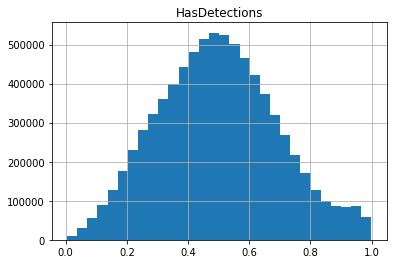

In [6]:
df_submission=pd.read_csv("../input/nffm-baseline-0-690-on-lb/nffm_submission.csv")
df_submission.hist(bins=30)
df_submission.head()

# Save original submission for comparison

In [7]:
df_submission.to_csv("original_submission.csv",index=None)

## Test private split impact, is private  >=26 oct 2018?

If so, zeroing predictions >= 26-oct-2018, should affect only Private LB and not Public LB (.690)

updated 19-02-2019, also filter other dates >=26-oct-2018, recover some extra private split rows, result is the same

In [8]:
print("using only AvSigVersion Date, private split rows:",
      df_submission.loc[(df_kaggle_test.DateAS>="2018-10-26")].shape)

print("using all Dates available, private split rows:",
      df_submission.loc[(df_kaggle_test.DateAS>="2018-10-26")
                  | (df_kaggle_test.DateBL>="2018-10-26")
                  | (df_kaggle_test.DateOS>="2018-10-26")].shape)

using only AvSigVersion Date, private split rows: (2397738, 2)
using all Dates available, private split rows: (2420130, 2)


# Zero predictions in public test rows <2018-10-26, if submitted public LB result should be really bad

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.503945
1,00000176ac758d54827acd545b6315a5,0.000000
2,0000019dcefc128c2d4387c1273dae1d,0.000000
3,0000055553dc51b1295785415f1a224d,0.339152
4,00000574cefffeca83ec8adf9285b2bf,0.000000


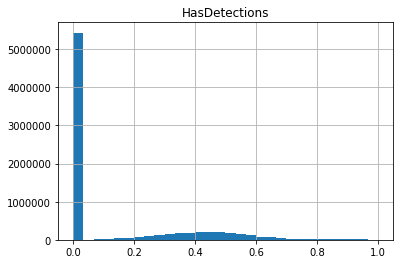

In [9]:
df_private_submission=df_submission.copy()
df_private_submission.loc[~ ((df_kaggle_test.DateAS>="2018-10-26")
                  | (df_kaggle_test.DateBL>="2018-10-26")
                  | (df_kaggle_test.DateOS>="2018-10-26")),"HasDetections"]=0
df_private_submission.hist(bins=30)
df_private_submission.head()


In [10]:
df_private_submission.to_csv("private_lb_submission.csv",index=None)

# Zero predictions in private test rows >=2018-10-26, if submitted result should not be affected in public LB

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.000000
1,00000176ac758d54827acd545b6315a5,0.577533
2,0000019dcefc128c2d4387c1273dae1d,0.606817
3,0000055553dc51b1295785415f1a224d,0.000000
4,00000574cefffeca83ec8adf9285b2bf,0.460082


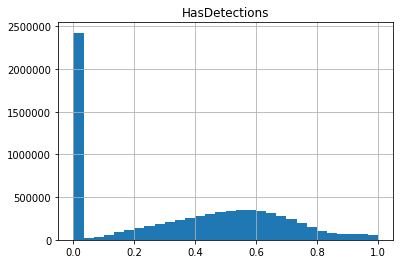

In [11]:
df_submission.loc[(df_kaggle_test.DateAS>="2018-10-26")
                  | (df_kaggle_test.DateBL>="2018-10-26")
                  | (df_kaggle_test.DateOS>="2018-10-26"),"HasDetections"]=0
df_submission.hist(bins=30)
df_submission.head()

# Save to compare submissions, final result is same!

in this specific case, scores .688 for both files (actual result depending on nnfm kernel submission)
for private_lb_submission public score is .5 auc as expected

In [12]:
df_submission.to_csv("public_lb_submission.csv",index=None)

# So, what's next?

- makes sense? 
- is private really one day or two days?
- what can we do with this?
- thoughts? comments?

thanks!
